# Import

In [1]:
import fastavro
import pandas as pd
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE

import matplotlib.pyplot as plt
import seaborn as sns

# Read Avro & Create DataFrame

In [3]:
avro_file = 'songs_advanced.avro'

with open(avro_file, 'rb') as f:
    avro_data = list(fastavro.reader(f))

df = pd.DataFrame.from_records(avro_data)

# 指定要填充NaN值的列
columns_to_fill = ['bar_num','beat_num','segments_loudness_max_time_mean','artist_familiarity', 'key','duration', 'end_of_fade_in', 'loudness', 'tempo', 'time_signature']

# 以均值填充指定的列
df[columns_to_fill] = df[columns_to_fill].fillna(df[columns_to_fill].mean())

df_selected = df.loc[:,columns_to_fill]



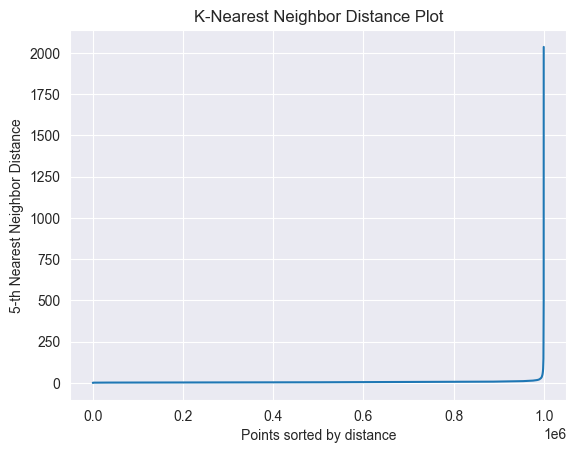

In [4]:
# 计算 K-邻近距离
min_samples = 5  # 可以根据数据集和领域知识选择
neigh = NearestNeighbors(n_neighbors=min_samples)
nbrs = neigh.fit(df_selected)
distances, indices = nbrs.kneighbors(df_selected)

# 取每个点的第 min_samples 近的距离
k_distances = distances[:, min_samples - 1]
k_distances = np.sort(k_distances)

# 绘制 K-邻近距离图
plt.plot(k_distances)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{min_samples}-th Nearest Neighbor Distance')
plt.title('K-Nearest Neighbor Distance Plot')
plt.show()

# Train DBSCAN model

In [20]:
dbscan = DBSCAN(eps=10, min_samples=5)
dbscan.fit(df_selected)
labeled_df = df.copy()
labeled_df['Cluster'] = dbscan.labels_

# Visualization by PCA

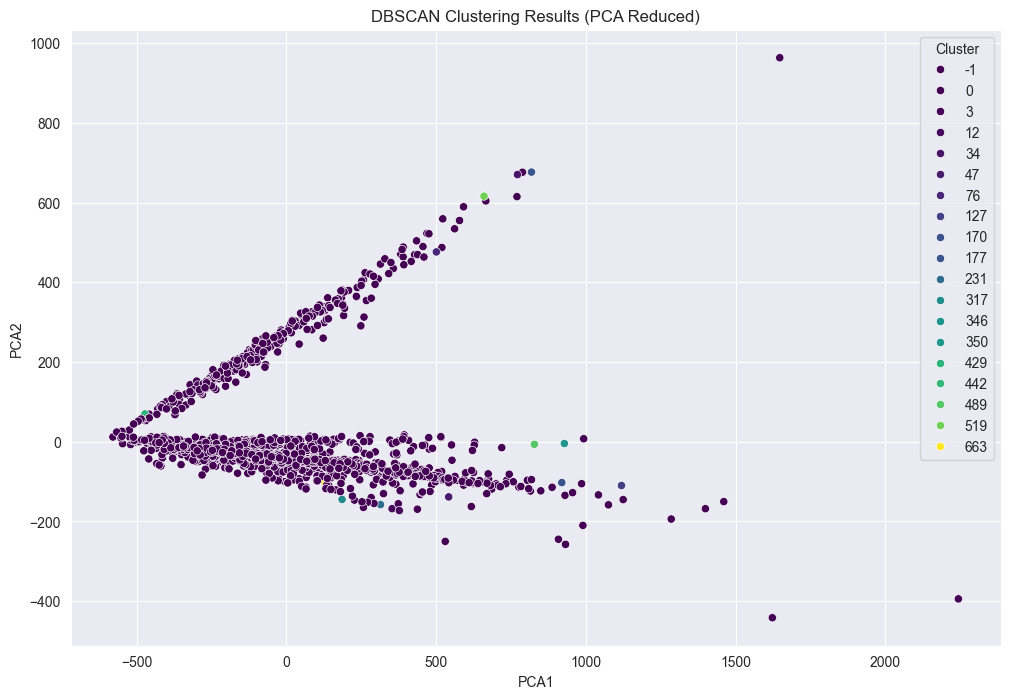

In [29]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df_selected)

# 创建一个新的DataFrame用于可视化
visual_df = pd.DataFrame(df_pca, columns=['PCA1', 'PCA2'])
visual_df['Cluster'] = labeled_df['Cluster']

# 随机采样（如果数据点过多）
sample_size = 2000  # 设置采样大小，根据需要调整
if len(visual_df) > sample_size:
    visual_df = visual_df.sample(n=sample_size, random_state=42)
    
# 绘制聚类结果
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PCA1', y='PCA2', 
    hue='Cluster', 
    palette='viridis', 
    data=visual_df,
    legend='full'
)
plt.title('DBSCAN Clustering Results (PCA Reduced)')
plt.show()

# Find most similar songs in the cluster

In [36]:
def getNMostRelatedSongs(song_id, labeled_df, n=10):
    song = labeled_df[labeled_df["song_id"] == song_id]
    
    if song.empty:
        return pd.DataFrame()  # Return empty DataFrame if song_id not found
    song_cluster = song["Cluster"].values[0]
    if song_cluster == -1:
        return pd.DataFrame()  # Return empty DataFrame if the song is an outlier

    cluster_songs = labeled_df[labeled_df["Cluster"] == song_cluster]
    features_numpy = cluster_songs.loc[:, columns_to_fill].to_numpy()

    song_numpy = song.loc[:, columns_to_fill].to_numpy()

    song_numpy_duplicate = np.tile(song_numpy, (features_numpy.shape[0], 1))
    cos_numpy = np.transpose(np.dot(features_numpy, np.transpose(song_numpy))) / np.transpose(np.linalg.norm(features_numpy, axis=1)) / np.transpose(np.linalg.norm(song_numpy_duplicate, axis=1))
    cos_numpy = np.transpose(cos_numpy)

    cluster_songs["Cos_correlation_factor"] = cos_numpy

    most_related_songs = cluster_songs.sort_values(by="Cos_correlation_factor", ascending=False).iloc[:n, :]
    return most_related_songs


In [37]:
song_id = b'SOCIWDW12A8C13D406'
n = 10

related_songs = getNMostRelatedSongs(song_id, labeled_df, n)

def selected_n_most_related_in_groupByDataFrame(df : pd.DataFrame):
    return (df.sort_values(by= "Cos_correlation_factor", ascending=False).iloc[:10, :])

related_songs.groupby(by = "Cluster").apply(selected_n_most_related_in_groupByDataFrame)
# print(related_songs)



C:\Users\oscar meng\AppData\Local\Temp\ipykernel_16640\2231968204.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_songs["Cos_correlation_factor"] = cos_numpy
C:\Users\oscar meng\AppData\Local\Temp\ipykernel_16640\40918143.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  related_songs.groupby(by = "Cluster").apply(selected_n_most_related_in_groupByDataFrame)


loudness  segments_loudness_max_mean  \
Cluster                                                
0       4         -9.843                  -12.450609   
        535386   -10.159                  -11.561128   
        331869    -9.433                  -11.105879   
        973942   -10.603                  -13.504078   
        281684    -9.142                  -10.639452   
        237319    -9.172                  -11.777238   
        45269     -9.979                  -12.318854   
        58453    -10.232                  -11.816943   
        987791    -8.152                   -9.709998   
        276321    -9.810                  -11.366538   

                segments_loudness_max_time_mean  artist_7digitalid  \
Cluster                                                              
0       4                              0.054163               1998   
        535386                         0.053575              98465   
        331869                         0.050018             185853   
        973942                         0.074867              20689   
        281684                         0.071025              35797   
        237319                         0.056537              23824   
        45269                          0.069257              10152   
        58453                          0.063126              97433   
        987791                         0.063150                330   
        276321                         0.063495              19152   

                time_signature  time_signature_confidence  \
Cluster                                                     
0       4                  4.0                      0.384   
        535386             4.0                      0.495   
        331869             4.0                      0.075   
        973942             4.0                      0.318   
        281684             4.0                      1.000   
        237319             4.0                      0.000   
        45269              4.0                      0.683   
        58453              4.0                      0.348   
        987791             4.0                      0.656   
        276321             4.0                      0.514   

                segments_confidence_mean  artist_familiarity  \
Cluster                                                        
0       4                       0.698873            0.630630   
        535386                  0.584701            0.406858   
        331869                  0.612735            0.391760   
        973942                  0.745785            0.568902   
        281684                  0.606790            0.295342   
        237319                  0.630396            0.686721   
        45269                   0.610566            0.589260   
        58453                   0.611829            0.491108   
        987791                  0.631502            0.517404   
        276321                  0.622044            0.520554   

                segments_pitches_mean  segments_start_mean  ...  \
Cluster                                                     ...   
0       4                    0.296259            72.893227  ...   
        535386               0.242541            71.193405  ...   
        331869               0.332639            72.074387  ...   
        973942               0.326360            73.800621  ...   
        281684               0.387453            70.549805  ...   
        237319               0.473036            73.499443  ...   
        45269                0.334330            73.850365  ...   
        58453                0.291189            73.517509  ...   
        987791               0.245155            73.462311  ...   
        276321               0.371457            72.726578  ...   

                artist_latitude  artist_terms_weight_mean  \
Cluster                                                     
0       4             35.149681                  0.671166   
        5353

In [23]:
labeled_df[labeled_df["song_id"] == song_id]

,loudness,segments_loudness_max_mean,segments_loudness_max_time_mean,artist_7digitalid,time_signature,time_signature_confidence,segments_confidence_mean,artist_familiarity,segments_pitches_mean,segments_start_mean,...,artist_longitude,artist_latitude,artist_terms_weight_mean,artist_terms_freq_mean,song_id,title,album_id,album_name,year,Cluster
4,-9.843,-12.450609,0.054163,1998,4.0,0.384,0.698873,0.63063,0.296259,72.893227,...,-90.04892,35.149681,0.671166,0.646709,b'SOCIWDW12A8C13D406',b'Soul Deep',300822,b'Dimensions',1969.0,0
